In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers, preprocessing
import yfinance as yf

In [2]:
df = yf.download("MSFT", start="2012-01-01", end="2022-01-01")
df.head(2)

C:\Users\admin\AppData\Local\Temp\ipykernel_13800\408282881.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("MSFT", start="2012-01-01", end="2022-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,
2012-01-03,21.004677,21.153756,20.706515,20.832056,64731500
2012-01-04,21.498987,21.553911,21.012515,21.043899,80516100


In [3]:
data = df["Close"].values
data[:5]

array([[21.00467682],
       [21.4989872 ],
       [21.71869278],
       [22.05608559],
       [21.76577759]])

In [4]:
data.shape

(2517, 1)

In [5]:
scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(data)
scaled_data[:5]

array([[0.        ],
       [0.00158634],
       [0.00229142],
       [0.00337418],
       [0.00244253]])

In [6]:
def create_seq(data, seq_len=60):
    X, y = [], []
    time_step = 60

    for i in range(len(data)-seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)
    
    # X = np.reshape(X, (X.shape[0], X.shape[1], 1)) # X = (2457, 60) To (2457, 60, 1)
    # X.shape, y.shape

In [7]:
SEQ_LEN = 60
X, y = create_seq(scaled_data, seq_len=SEQ_LEN)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
model = models.Sequential([
	layers.GRU(100, return_sequences=True, input_shape=(SEQ_LEN, 1), recurrent_dropout=0.2),
	layers.GRU(100, recurrent_dropout=0.2),
	layers.Dense(1)
])

c:\ProgramData\anaconda3\envs\tf\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
model.compile(optimizer="adam", loss="mse", metrics=["mse", "mae"])

In [11]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 0.0044 - mae: 0.0350 - mse: 0.0044 - val_loss: 6.0714e-05 - val_mae: 0.0053 - val_mse: 6.0714e-05
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 1.6717e-04 - mae: 0.0080 - mse: 1.6717e-04 - val_loss: 6.5129e-05 - val_mae: 0.0055 - val_mse: 6.5129e-05
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 1.4792e-04 - mae: 0.0075 - mse: 1.4792e-04 - val_loss: 7.7436e-05 - val_mae: 0.0052 - val_mse: 7.7436e-05
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 1.3879e-04 - mae: 0.0076 - mse: 1.3879e-04 - val_loss: 5.1740e-05 - val_mae: 0.0042 - val_mse: 5.1740e-05
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 1.2211e-04 - mae: 0.0068 - mse: 1.2211e-04 - val_loss: 4.8760e-05 - val_mae: 0.0046 - val_mse: 4.8760e-05
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 1.1552e-04 - mae: 0.0066 - mse: 1.1552e-04 - val_loss: 4.8558e-05 - val_mae: 0.0044 - val_mse: 4.8558e-05
Epoch 7/10
62/62 ━

In [12]:
pred = model.predict(X_test)

rescale_pred = scaler.inverse_transform(pred)
rescale_y_test = scaler.inverse_transform(y_test)

rescale_pred.shape, rescale_y_test.shape

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


((492, 1), (492, 1))

In [14]:
loss, mse, mae = model.evaluate(X_test, y_test)
print(f"Loss: {loss:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.2278e-05 - mae: 0.0044 - mse: 4.2278e-05
Loss: 0.0000, MSE: 0.0000, MAE: 0.0044


In [15]:
rmse = np.sqrt(mean_squared_error(rescale_y_test, rescale_pred))
r2 = r2_score(rescale_y_test, rescale_pred)
print("RMSE : ", rmse)
print("R2 : ", r2)

RMSE :  2.02609151971831
R2 :  0.9993121129361493


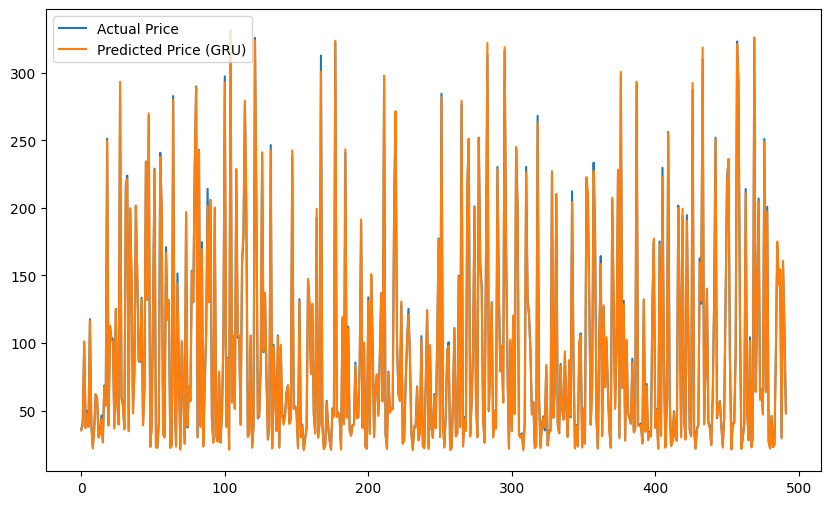

In [16]:
plt.figure(figsize=(10,6))
plt.plot(rescale_y_test, label="Actual Price")
plt.plot(rescale_pred, label="Predicted Price (GRU)")
plt.legend()
plt.show()